Be sure to install the dependencies:
```bash
conda install --yes msmbuilder pandas matplotlib seaborn scikit-learn
```
`msmbuilder` was just updated on 19 Oct 2016, so you might want to reinstall:
```bash
conda uninstall --yes scikit-learn msmbuilder
conda clean -pltis --yes
conda install --yes msmbuilder
```

In [1]:
%matplotlib inline

In [2]:
import matplotlib as mpl
mpl.use('Agg')
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import seaborn

import numpy as np
import pandas as pd

/Users/choderaj/miniconda/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [25]:
def read_patient_data(patient):
    filename = '%s_gordon.taxa_count.sorted.txt' % patient

    # Load data
    df = pd.read_table(filename, delim_whitespace=True)

    # Extract sorted sample labels
    samples = list(df.index)
    nsamples = len(samples)

    # Extract feature names
    features = list(df.columns)
    nfeatures = len(features)

    # Extract feature vectors
    patient_timeseries = df.as_matrix()

    return [samples, features, patient_timeseries]

Projecting all patient data...
Making figures...


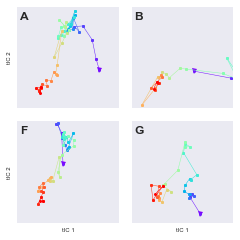

In [36]:
#
# Analyze
#

import msmbuilder.cluster
import msmbuilder.hmm
import sklearn.cluster
from msmbuilder.decomposition import tICA

n_components = 2 # number of dimensions to retain
lag_time = 1 # lag time (in sampling intervals)

#
# Perform tICA clustering on each depth separately
#

# Get colormap
from matplotlib.pyplot import cm

# Construct a tICA projection from all data.
print('Projecting all patient data...')
patients = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
data = list()
for (subplot_index, patient) in enumerate(patients):
    # Load patient data
    [samples, features, patient_timeseries] = read_patient_data(patient)
    data.append(patient_timeseries)
    nsamples = len(samples)
    nfeatures = len(features)
# Create tICA projection and retrieve projected data
tica = tICA(n_components=n_components, lag_time=lag_time)
projected_data = tica.fit_transform(data)

# Make plots
print('Making figures...')
fig = plt.figure(figsize=[3.5,3.5])
subplot_nx = 2
subplot_ny = 2
fontsize=6
patient_indices_to_plot = [0, 1, 5, 6]
for (plot_index, patient_index) in enumerate(patient_indices_to_plot):    
    patient = patients[patient_index]
    plot_column = plot_index % subplot_ny
    plot_row = plot_index / subplot_ny
    
    # Load patient data
    [samples, features, patient_timeseries] = read_patient_data(patient)
    nsamples = len(samples)
    nfeatures = len(features)
    projection = projected_data[patient_index]
    cmap = cm.rainbow(np.linspace(0,1,nsamples))
    
    ax = plt.subplot(subplot_ny, subplot_nx, plot_index+1)
    ax.set_color_cycle(cmap)
        
    # Compute tICA projection
    # NOTE: This sometimes failes because of missing values, so this is in a try...except clause
    #tica = tICA(n_components=n_components, lag_time=lag_time)
    #projection = tica.fit_transform([patient_timeseries])
    
    # Print eigenvalues
    #print('eigenvalues:')
    #print tica.eigenvalues_
    #projection = projection[0] # select out only trajectory

    # Plot with time-varying color
    projection = projected_data[patient_index]
    ax.plot(projection[0,0], projection[0,1], 'v', markersize=5);
    for i in range(nsamples-1):
        ax.plot(projection[i:i+2,0], projection[i:i+2,1], 'o-', markersize=3, linewidth=0.5);
    
    # Title subplot
    #plt.title('patient %s' % patient, fontsize=fontsize)

    # Fix up axes.
    if plot_column == 0:
        plt.ylabel('tIC 2', fontsize=fontsize)
    if plot_row == (subplot_ny-1):
        plt.xlabel('tIC 1', fontsize=fontsize)
    plt.xticks([])
    plt.yticks([])

    plt.axis('square')
    plt.axis([-2, +2, -2, +2])
    ax.text(-1.9, +1.5,  patient, fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('panel.pdf')